In [2]:
import sys
import os
from pathlib import Path

# importディレクトリの追加
# sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
print(sys.path)

# プロキシの設定
# os.environ['HTTP_PROXY'] = ''
# os.environ['HTTPS_PROXY'] = ''

%matplotlib inline

['/home/y-katayama/notebooks/dl_study/02_pytorch_tutorial', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/y-katayama/venv/pt1.7/lib/python3.8/site-packages']


In [3]:
!nvidia-smi

Wed Dec 14 16:47:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| 40%   31C    P8    17W / 184W |     47MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:03:00.0 Off |                  N/A |
| 40%   

# クラス分類の学習方法

- 画像, テキスト, 音声, 動画などのデータを扱う場合は, numpy配列にデータを読み込んだり標準的なPythonパッケージを利用する

    - 画像: Pillow, OpenCV
    - 音声: scipy, librosa
    - テキスト: Python/Cython, NLTK, SpaCy

- PyTorchでは画像データのためにImagenetやCIFAR10, MNISTを簡単に扱える`torchvision`パッケージがある

  - torchvision.datasets やtorch.utils.data.DataLoaderが含まれ, これらはユーザーに多くの便利な機能を提供します。

## CIFAR10の読み込みと正規化

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# 学習用DataLoaderを定義
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

# テスト用DataLoaderを定義
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


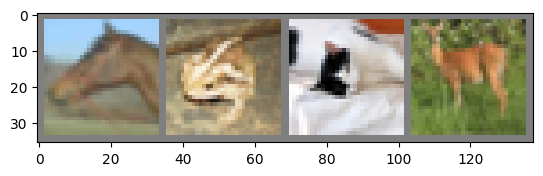

horse  frog   cat  deer


In [6]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    """パラメータimgで与えられた画像を表示する"""
    
    img = img / 2 + 0.5    # 正規化を戻す
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# 適当な訓練セットの画像を取得
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 画像の表示
imshow(torchvision.utils.make_grid(images))

# ラベルの表示
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 畳み込みニューラルネットワークの定義

In [7]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## 損失関数とオプティマイザの定義

- 損失はクロスエントロピー誤差
- 最適化はmomentumつきのSGD

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## ネットワークの訓練

In [9]:
for epoch in range(2):
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        
        # データセットのデータを[inputs, labels]のtupleで取得
        inputs, labels = data
        
        # パラメータの勾配をリセット
        optimizer.zero_grad()
        
        # 順伝播
        outputs = net(inputs)
        # 損失計算&逆伝播
        loss = criterion(outputs, labels)
        loss.backward()
        # パラメータ更新
        optimizer.step()
        
        # 統計情報の表示
        running_loss += loss.item()
        
        if i % 2000 == 1999:    # 2000に似バッチにつき一回だけ表示
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            
print('Fininshed training')

[1,  2000] loss: 2.196
[1,  4000] loss: 1.844
[1,  6000] loss: 1.674
[1,  8000] loss: 1.573
[1, 10000] loss: 1.516
[1, 12000] loss: 1.468
[2,  2000] loss: 1.395
[2,  4000] loss: 1.374
[2,  6000] loss: 1.341
[2,  8000] loss: 1.326
[2, 10000] loss: 1.285
[2, 12000] loss: 1.309
Fininshed training


In [10]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## テストデータでネットワークをテスト

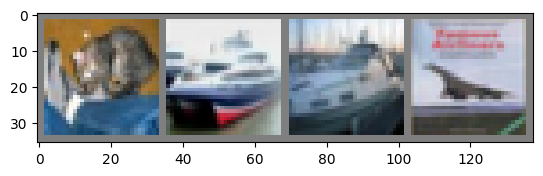

GroundTruth:    cat  ship  ship plane


In [11]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# 画像と正解ラベルの表示
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [12]:
del net

In [13]:
net = Net()
net.load_state_dict(torch.load(PATH))
outputs = net(images)

In [15]:
_, predicted = torch.max(outputs, 1)

# 最も信頼度が高いカテゴリを表示
print(predicted)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

tensor([3, 8, 1, 0])
Predicted:    cat  ship   car plane


In [16]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        # ラベルが一致しているバッチの総和を取る
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the 10000 test images: ', 100 * correct / total)

Accuracy of the network on the 10000 test images:  54.16


## うまく分類できたクラスと, できなかったクラスを分類

In [21]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
for i in range(10):
    print(f'Accuracy of {classes[i]}: {100 * class_correct[i] / class_total[i]}')

Accuracy of plane: 62.9
Accuracy of car: 64.7
Accuracy of bird: 20.7
Accuracy of cat: 36.5
Accuracy of deer: 64.0
Accuracy of dog: 46.5
Accuracy of frog: 45.6
Accuracy of horse: 72.2
Accuracy of ship: 68.2
Accuracy of truck: 60.3


# GPUで学習する方法

- PyTorch上からCUDAが見えていれば, GPUを使用することができる

In [24]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [25]:
# ネットワーク内の全モジュールを再帰的に調べて, パラメータとバッファをCUDAテンソルに変換する
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)